In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.fft import rfft, rfftfreq
import matplotlib

def make_rfft(data, sample_rate=500.5005):
    yf = rfft(data)
    xf = rfftfreq(len(data), 1 / sample_rate)
    return xf, np.abs(yf)

# Performance Comparison

calculate time and freq RMSE

In [2]:
dataset = "mfred"
# dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

all_freq_results, all_time_results = [], []
detail_time_results, detail_freq_results = [], []
# loop for seeds
for i in range(20):
    # for i in range(len(proposed_preds)):
    proposed_model = {"Proposed": proposed_preds[i]}
    all_preds = {
        **proposed_model,
        **bench_raw_preds[i],
        **bench_bu_preds[i],
        **bench_opt_preds[i]
    }
    freq_result = {name: {} for name in sorted(all_preds.keys())}
    time_result = {name: {} for name in sorted(all_preds.keys())}
    d_freq_result = {name: {} for name in sorted(all_preds.keys())}
    d_time_result = {name: {} for name in sorted(all_preds.keys())}

    # loop for models
    for name in sorted(all_preds.keys()):
        all_term_preds = all_preds[name]
        # loop for avg terms
        for avg_terms in sorted(all_term_preds.keys()):
            preds, labels = all_term_preds[avg_terms]
            error_freq = []
            # loop for samples
            for n in range(len(preds)):
                xf_true, yf_true = make_rfft(labels[n].flatten(), 1)
                xf_pred, yf_pred = make_rfft(preds[n].flatten(), 1)
                error_freq.append((((yf_true) - (yf_pred))**2).mean())

            freq_result[name][avg_terms] = np.sqrt(error_freq).mean()
            # time_result[name][avg_terms] = np.sqrt(((labels.squeeze() - preds.squeeze()) ** 2).mean(axis=1)).mean()
            time_result[name][avg_terms] = mean_squared_error(labels.squeeze(),
                                                              preds.squeeze(),
                                                              squared=False)
            d_freq_result[name][avg_terms] = np.sqrt(error_freq).flatten()
            d_time_result[name][avg_terms] = np.sqrt(
                ((labels.squeeze() -
                  preds.squeeze())**2).mean(axis=1)).flatten()
    df_freq_result = pd.DataFrame(freq_result)
    df_time_result = pd.DataFrame(time_result)
    all_freq_results.append(df_freq_result)
    all_time_results.append(df_time_result)
    detail_freq_results.append(d_freq_result)
    detail_time_results.append(d_time_result)
all_freq_results = pd.concat(all_freq_results, axis=0)
all_freq_results = all_freq_results.groupby(all_freq_results.index).agg(
    ["mean", "std"])
all_freq_results = all_freq_results.sort_index()

all_time_results = pd.concat(all_time_results, axis=0)
all_time_results = all_time_results.groupby(all_time_results.index).agg(
    ["mean", "std"])
all_time_results = all_time_results.sort_index()
all_time_results = all_time_results.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)
all_freq_results = all_freq_results.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)

try:
    all_time_results = all_time_results.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)
    all_freq_results = all_freq_results.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)
except:
    pass

all_time_results.rename(index={
    "Neural Laplace": "NL",
    "Neural Laplace-BU": "NL-BU",
    "Neural Laplace-OPT": "NL-OPT",
    "Proposed": "HL"
},
                        inplace=True)
all_freq_results.rename(index={
    "Neural Laplace": "NL",
    "Neural Laplace-BU": "NL-BU",
    "Neural Laplace-OPT": "NL-OPT",
    "Proposed": "HL"
},
                        inplace=True)
print(all_time_results)
print(all_freq_results)
# all_time_results.to_csv(f"savings/time_rmse_{dataset}.csv")
# all_freq_results.to_csv(f"savings/freq_rmse_{dataset}.csv")

                 mean       std      mean       std      mean       std
                   1         1         3         3         12        12
LSTM         0.037513  0.001422  0.038092  0.001920  0.037458  0.001586
LSTM-BU      0.037513  0.001422  0.037078  0.001437  0.036215  0.001460
LSTM-OPT     0.035970  0.000988  0.035516  0.000998  0.034632  0.001015
MLP          0.035908  0.000672  0.033310  0.001142  0.031302  0.000397
MLP-BU       0.035908  0.000672  0.035471  0.000685  0.034617  0.000707
MLP-OPT      0.033721  0.000597  0.033254  0.000607  0.032359  0.000624
NL           0.036382  0.001293  0.035790  0.001635  0.035025  0.001495
NL-BU        0.036382  0.001293  0.035953  0.001306  0.035006  0.001321
NL-OPT       0.035306  0.000985  0.034865  0.000996  0.033898  0.001008
Persistence  0.036967  0.000000  0.036149  0.000000  0.034785  0.000000
HL           0.034279  0.000822  0.033594  0.000786  0.033597  0.000680
                 mean       std      mean       std      mean   

Spining bar chart

In [3]:
all_opt_result = all_time_results
for i in [1,3,12]:
    all_opt_result.loc[:, ("mean",i)] /= (all_opt_result.loc["Persistence", ("mean",i)])
series_opt = all_opt_result["mean"].unstack()
df = series_opt.reset_index()
df.columns=["avg_terms", "methods","value"]
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment
def add_model_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 0.01
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):

        angle = angle
        
        if label == "HL":
            kw={"fontweight":"bold","fontsize":16}
        else:
            kw={"fontsize":14}
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",**kw
        )
def add_number_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 0.25
    count = 0
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        if (label not in ["Persistence", "HL"]):
            continue

        angle = angle
        
        if label == "HL":
            kw={"fontweight":"bold", "fontsize":15}
        else:
            kw={"fontsize":15}
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value-padding, 
            s="{:.2f}".format(value), 
            ha=alignment, 
            c="white",
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",**kw
        )
        count+=1
ANGLES = np.linspace(0, 2 * np.pi, len(df), endpoint=False)
VALUES = df["value"].values
LABELS = df["methods"].values

# Determine the width of each bar. 
# The circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2


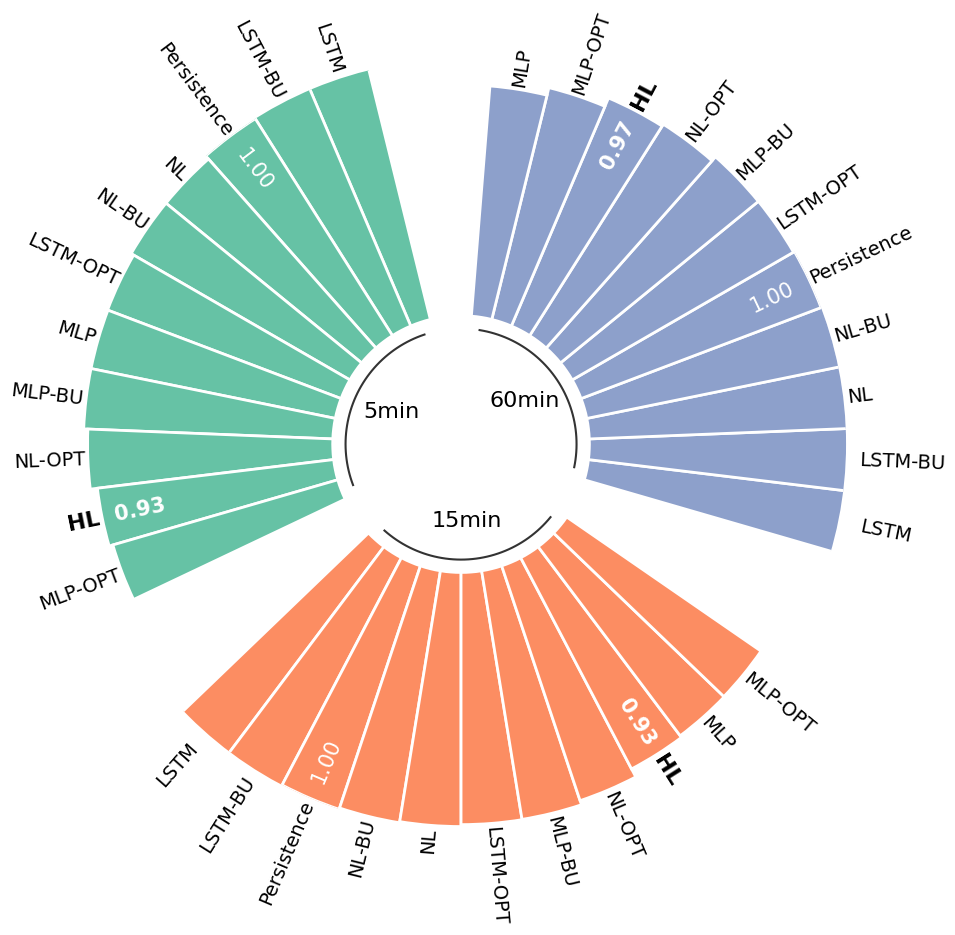

In [4]:
df_sorted = (
    df
    .groupby(["avg_terms"])
    .apply(lambda x: x.sort_values(["value"], ascending = False))
    .reset_index(drop=True)
)
VALUES = df_sorted["value"].values 
LABELS = df_sorted["methods"].values
GROUP = df_sorted["avg_terms"].values

PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))

start = 0
ANGLES = np.linspace(start, 2 * np.pi+start, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

GROUPS_SIZE = [len(i[1]) for i in df.groupby("avg_terms")]

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-0.5,1)
# ax.set_ylim(-0.3,0.6)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [len(i[1]) for i in df.groupby("avg_terms")]
COLORS = [plt.get_cmap("Set2").colors[i] for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# Add bars to represent ...
OFFSET = np.pi/2
ax.set_theta_offset(OFFSET)
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_model_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)
add_number_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)
# print(ANGLES)
# print(PAD)

offset = 0

for group, size in zip(["5min", "15min", "60min"], GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-0.05] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -0.2, group, fontsize=16, ha="center", va="center"
        # np.mean(x1), -0.125, group, fontsize=14, ha="center", va="center"
    )
    
    # # Add reference lines at 20, 40, 60, and 80
    # x2 = np.linspace(ANGLES[offset+PAD],ANGLES[offset + size + 1],  num=50)
    # x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    # ax.plot(x2, [1.5] * 50, color="#bebebe", lw=0.8)
    # ax.plot(x2, [0.04] * 50, color="#bebebe", lw=0.8)
    # ax.plot(x2, [0.06] * 50, color="#bebebe", lw=0.8)
    # ax.plot(x2, [0.08] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD
# fig.savefig("savings/load.pdf",bbox_inches="tight")
# fig.savefig("savings/wind.pdf",bbox_inches="tight")
# fig.savefig("savings/single_res_costs.pdf",bbox_inches="tight")


In [5]:
with open(f'savings/large_ramp_opt_20_{dataset}_new.pickle', 'rb') as handle:
    proposed_opt = pickle.load(handle)
    print(len(proposed_opt))

all_opt_result = []
xs, ys, zs = [], [], []
for seed in range(20):
    seed_opt = proposed_opt[seed]

    opt_result = {name: {} for name in seed_opt.keys()}
    for name in seed_opt.keys():
        if name.__contains__("Persistence"):
            continue
        res_opt = seed_opt[name]
        sample_opt = np.array(res_opt[1][:7])

        # For scatter plot (day-ahead scheduling for one week)
        x = detail_time_results[seed][name][1][23:23+7*24][::24]
        y = detail_freq_results[seed][name][1][23:23+7*24][::24]
        z = sample_opt
        xs.append(x)
        ys.append(y)
        zs.append(z)

xs = np.array(xs).flatten()
ys = np.array(ys).flatten()
zs = np.array(zs).flatten()


20


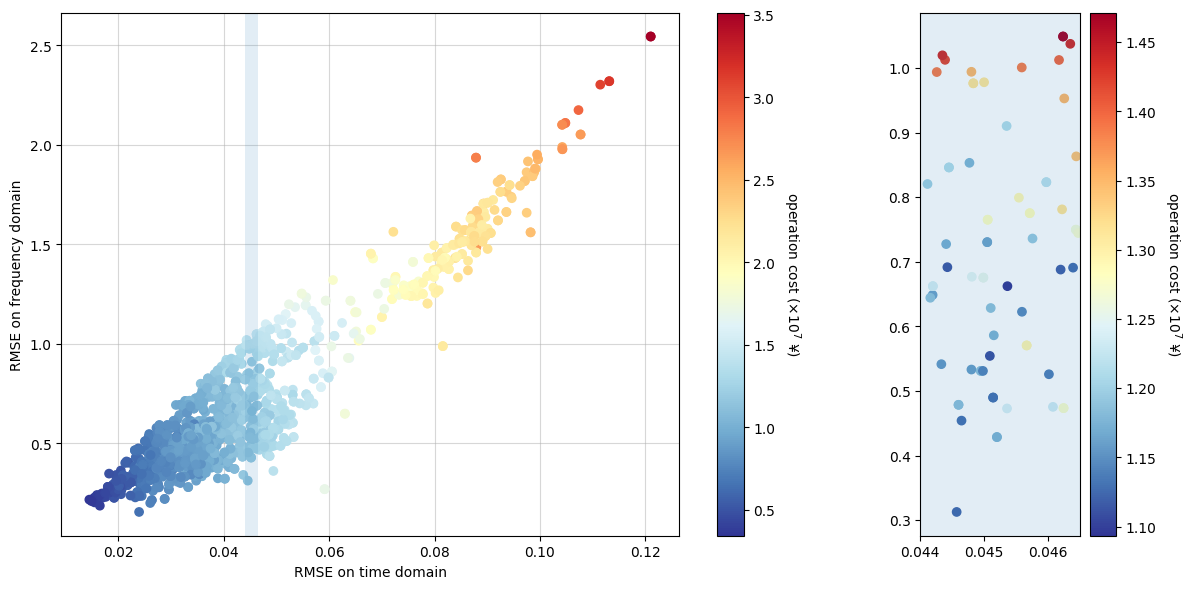

In [6]:
from matplotlib.transforms import (TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector,
                                                   BboxConnectorPatch,
                                                   BboxPatch)


def connect_bbox(bbox1,
                 bbox2,
                 loc1a,
                 loc2a,
                 loc1b,
                 loc2b,
                 prop_lines,
                 prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(bbox1,
                       bbox2,
                       loc1=loc1a,
                       loc2=loc2a,
                       clip_on=False,
                       **prop_lines)
    c2 = BboxConnector(bbox1,
                       bbox2,
                       loc1=loc1b,
                       loc2=loc2b,
                       clip_on=False,
                       **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1,
                           bbox2,
                           loc1a=loc1a,
                           loc2a=loc2a,
                           loc1b=loc1b,
                           loc2b=loc2b,
                           clip_on=False,
                           ec="none")
    # p = BboxConnectorPatch(bbox1, bbox2,
    #                        loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
    #                        clip_on=False,
    #                        **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    # prop_patches = {"ec": "none", "alpha": 0.1}
    prop_patches = {**kwargs, "ec": "none"}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=4,
        loc1b=2,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    # ax2.add_patch(c1)
    # ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


axs = plt.figure(figsize=[12, 6]).subplot_mosaic(
    [["main", "main", "main", "zoom1"]
     # [""],
     ])

p = axs["main"].scatter(xs, ys, c=zs / 1e7, cmap="RdYlBu_r")
axs["main"].set_axisbelow(True)
axs["main"].grid(alpha=0.5)
cbar = axs["main"].figure.colorbar(p, ax=axs["main"])
cbar.ax.set_ylabel("operation cost ($\\times 10^7$ ¥)",
                   rotation=-90,
                   va="bottom")

df = pd.DataFrame(np.stack([xs, ys, zs], axis=1),
                  columns=["time", "freq", "cost"])
df = df[df["time"].between(0.044, 0.0465)]
axs["zoom1"].set(xlim=(0.044, 0.0465))

p = axs["zoom1"].scatter(df["time"],
                         df["freq"],
                         c=df["cost"] / 1e7,
                         cmap="RdYlBu_r")
cbar = axs["zoom1"].figure.colorbar(p, ax=axs["zoom1"])
cbar.ax.set_ylabel("operation cost ($\\times 10^7$ ¥)",
                   rotation=-90,
                   va="bottom")
zoom_effect02(axs["zoom1"], axs["main"], alpha=0.125)
axs["main"].set_xlabel("RMSE on time domain")
axs["main"].set_ylabel("RMSE on frequency domain")
plt.tight_layout()
# plt.savefig("savings/relationship_zoom_new.pdf", bbox_inches="tight")


20


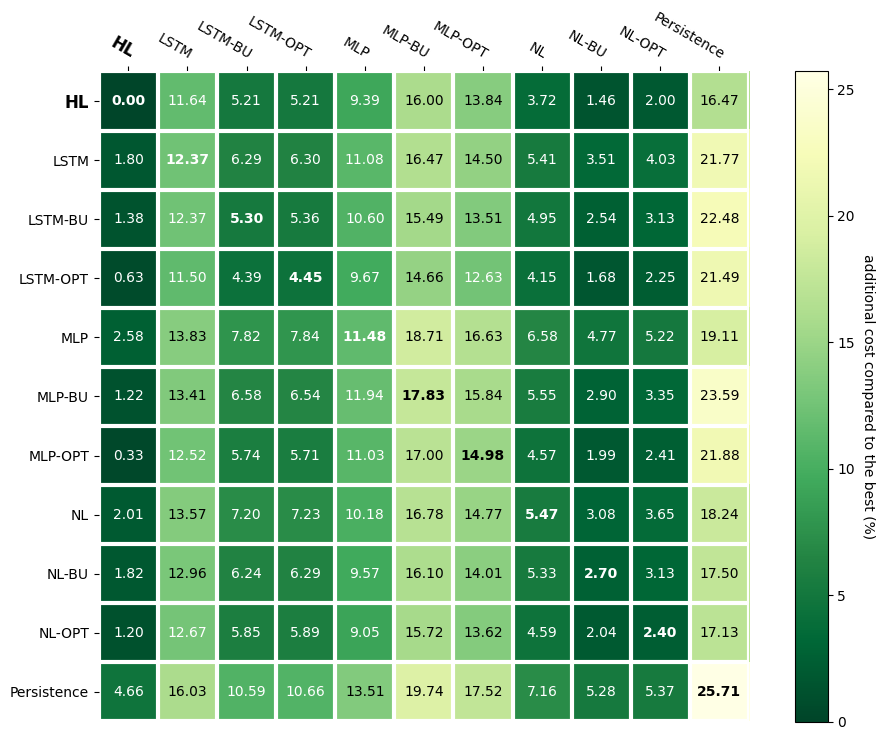

In [7]:
def heatmap(data,
            row_labels,
            col_labels,
            ax=None,
            cbar_kw=None,
            cbarlabel="",
            **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=-30,
             ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im,
                     data=None,
                     valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None,
                     **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if i!=j:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw, weight="bold")

            texts.append(text)

    return texts


peneration_rate = 0.5
with open(f'savings/daid_all_strict_pn_{peneration_rate}.pickle', 'rb') as handle:
    proposed_opt, names = pickle.load(handle)


for i, c in enumerate(names):
    if c=="Neural Laplace":
        names[i] = "NL"
    if c=="Neural Laplace-BU":
        names[i] = "NL-BU"
    if c=="Neural Laplace-OPT":
        names[i] = "NL-OPT"
    if c=="Proposed":
        names[i] = "HL"
temp = names.pop()
names.insert(0, temp)
print(len(proposed_opt))
proposed_opt = np.mean(proposed_opt, axis=0)
# print(proposed_opt.shape)
proposed_opt = proposed_opt[:,:,-1]
# 5, 12
# proposed_opt = proposed_opt[6][..., -1]
proposed_opt = np.block([[proposed_opt[-1,-1],proposed_opt[-1,:-1].reshape(1,-1)],[proposed_opt[:-1,-1].reshape(-1,1),proposed_opt[:-1,:-1]]])

# print(proposed_opt)
# final_cost = (proposed_opt)/1e6
final_cost = (proposed_opt - proposed_opt.min())/proposed_opt.min() * 100
fig, ax = plt.subplots(figsize=[4*2.5, 3*2.5])
im, cbar = heatmap(final_cost,
                names,names,
                   ax=ax,
                   cmap="YlGn_r",
                   cbarlabel="additional cost compared to the best (%)")
# texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=("black","white",))
texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=("white","black",))
for i, tick in enumerate(ax.get_yticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
for i, tick in enumerate(ax.get_xticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.tight_layout()
# fig.savefig(f"savings/loadwind_{peneration_rate}_all.pdf")

bar plots

In [8]:
with open(f'savings/large_ramp_opt_20_{dataset}_new.pickle', 'rb') as handle:
    proposed_opt = pickle.load(handle)
    print(len(proposed_opt))

all_opt_result = []
for seed in range(20):
    seed_opt = proposed_opt[seed]
    opt_result = {name: {} for name in seed_opt.keys()}
    for name in seed_opt.keys():
        res_opt = seed_opt[name]
        for avg_terms in res_opt.keys():
            sample_opt = res_opt[avg_terms][:7]
            opt_result[name][avg_terms] = np.mean(sample_opt)
    opt_result = pd.DataFrame(opt_result)
    all_opt_result.append(opt_result)
all_opt_result = pd.concat(all_opt_result, axis=0)
all_opt_result = all_opt_result.groupby(all_opt_result.index).agg(
    ["mean", "std"])
all_opt_result = all_opt_result.sort_index()
all_opt_result = all_opt_result.stack(level=1).transpose().swaplevel(1, 0, axis=1)

all_opt_result.rename(index={
    "Neural Laplace": "NL",
    "Neural Laplace-BU": "NL-BU",
    "Neural Laplace-OPT": "NL-OPT",
    "Proposed": "HL"
},
                        inplace=True)
all_opt_result = all_opt_result.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)

all_opt_result


20


,mean,std,mean,std,mean,std
,1,1,3,3,12,12
LSTM,1.239024e+07,1.030938e+06,4.163017e+06,285208.097430,1.038013e+06,79653.073360
LSTM-BU,1.239024e+07,1.030938e+06,4.263492e+06,346136.856148,1.056554e+06,86494.224085
LSTM-OPT,1.179414e+07,6.292470e+05,4.061903e+06,212652.906548,1.005638e+06,53267.196983
MLP,1.234261e+07,8.960359e+05,3.965374e+06,374512.044673,9.126738e+05,71977.028342
MLP-BU,1.234261e+07,8.960359e+05,4.246371e+06,301113.145024,1.049615e+06,75733.868104
MLP-OPT,1.155590e+07,6.105224e+05,3.981250e+06,204145.173413,9.837530e+05,51741.252042
NL,1.196412e+07,5.979884e+05,4.051451e+06,290969.143623,9.976918e+05,59432.828361
NL-BU,1.196412e+07,5.979884e+05,4.125662e+06,201660.588455,1.020373e+06,50387.145386
NL-OPT,1.163769e+07,4.509237e+05,4.016644e+06,151703.736421,9.933955e+05,37126.136133


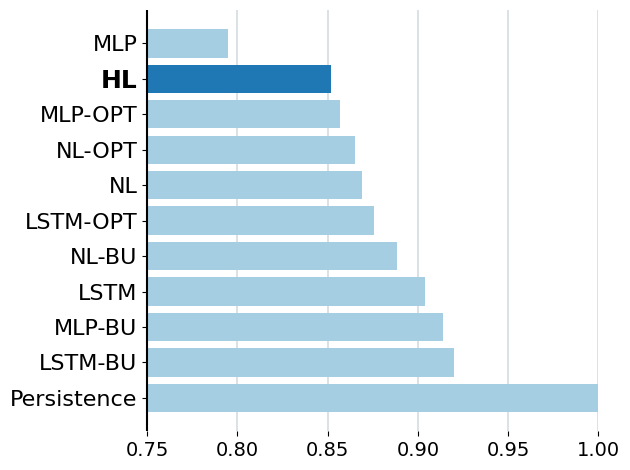

In [9]:
fig, ax = plt.subplots()
avg_terms = 12

# # For frequency
# all_opt_result = all_freq_results
# bar_freq = all_freq_results[("mean",1)]
# bar_freq = bar_freq.drop(labels=["LSTM-BU","MLP-BU","NL-BU","Persistence"])

# For operation
all_opt_result = all_opt_result
bar_freq = all_opt_result[("mean",avg_terms)]/all_opt_result.loc["Persistence",("mean",avg_terms)]
ax.set_xlim(0.75, 1)


bar_freq = bar_freq.sort_values(ascending=False)

bars = []
for name in bar_freq.index.tolist():
    if name.__contains__("HL"):
        c = plt.get_cmap("Paired").colors[1]
    else:
        c= plt.get_cmap("Paired").colors[0]
    b = ax.barh(name,
            bar_freq[name],
            color=c)
    bars.append(b)

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2,visible=True, which="both",alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
# ax.set_xlabel("operational cost")
for i, tick in enumerate(ax.get_yticklabels()):
    tick.set_fontsize(16)

    if i == (len(ax.get_yticklabels())-2):
        tick.set_fontweight('bold')
        tick.set_fontsize(18)
ax.xaxis.set_tick_params(labelsize=14)
fig.tight_layout()
# fig.savefig(f"savings/day_ahead_cost_{avg_terms}.pdf", bbox_inches="tight")

In [10]:
# dataset = "mfred"
dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

all_freq_results, all_time_results = [], []
detail_time_results, detail_freq_results = [], []
# loop for seeds

# seed = np.random.permutation(20)[0]
# sample = 110

min_e = np.inf
for seed in range(20):
    for sample in range(435):

        # for i in range(len(proposed_preds)):
        proposed_model = {"Proposed": proposed_preds[seed]}
        all_preds = {
            **proposed_model,
            **bench_raw_preds[seed],
            **bench_bu_preds[seed],
            **bench_opt_preds[seed]
        }

        all_term_preds = all_preds["Proposed"]

        error = 0
        for j, avg_terms in enumerate(sorted(all_term_preds.keys())):
            preds, labels = all_term_preds[avg_terms][0:288//3]
            error += mean_squared_error(preds[sample].squeeze()[0:288//3], labels[sample].squeeze()[0:288//3])
        if error< min_e:
            min_e = error

Curve plot

4
93


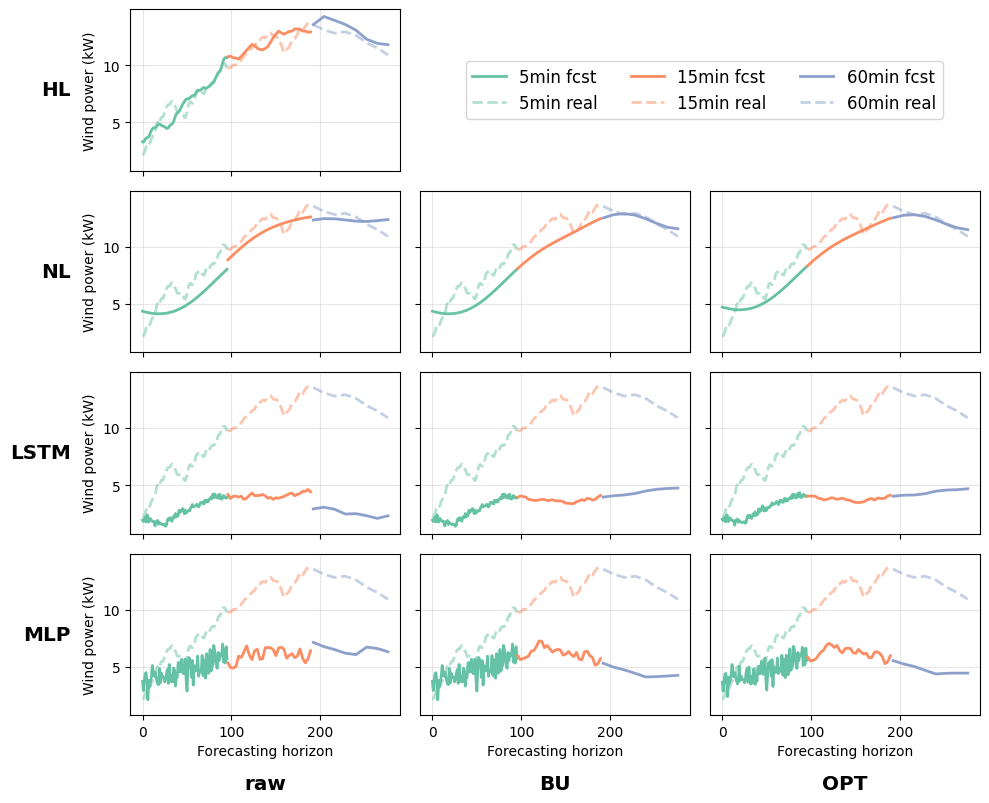

In [11]:
# dataset = "mfred"
dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

all_freq_results, all_time_results = [], []
detail_time_results, detail_freq_results = [], []
# loop for seeds

seed = 4
sample = 93

# seed = np.random.permutation(20)[0]
# sample = np.random.permutation(400)[0]
print(seed)
print(sample)
proposed_model = {"Proposed": proposed_preds[seed]}
all_preds = {
    **proposed_model,
    **bench_raw_preds[seed],
    **bench_bu_preds[seed],
    **bench_opt_preds[seed]
}

names = [
    "Proposed","Neural Laplace", "Neural Laplace-BU", "Neural Laplace-OPT", "LSTM", "LSTM-BU", "LSTM-OPT", "MLP", "MLP-BU", "MLP-OPT",
    
]
plt_names = {
    "Proposed": "HL",
    "Neural Laplace": "NL",
    "Neural Laplace-BU": "NL-BU",
    "Neural Laplace-OPT": "NL-OPT",
    "LSTM": "LSTM",
    "LSTM-BU": "LSTM-BU",
    "LSTM-OPT": "LSTM-OPT",
    "MLP": "MLP",
    "MLP-BU": "MLP-BU",
    "MLP-OPT": "MLP-OPT",
}

# names = ["Proposed", "LSTM", "MLP", "Neural Laplace"]
# plt_names = {"Proposed":"HL", "LSTM":"LSTM", "MLP":"MLP", "Neural Laplace":"NL"}
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True,figsize=[10, 8])
pad = 5

cols = ["raw","BU","OPT"]
rows = ["HL","NL","LSTM","MLP"]

for ax, col in zip(axs[-1,:], cols):
    ax.annotate(col, xy=(0.5, -0.5), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',weight="bold",
                size='x-large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    # if row =="HL":
    #     kwargs = {"weight":"bold"}
    # else:
    #     kwargs = {}

    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points', weight="bold",
                size='x-large', ha='right', va='center')


axs = axs.flatten()

# axs = np.concatenate([axs[1], axs[3:].reshape(1,-1)]).flatten()
for i, name in enumerate(names):
    if i ==0:
        k = 0
    else:
        k = i+2
    all_term_preds = all_preds[name]
    start = 0
    for j, avg_terms in enumerate(sorted(all_term_preds.keys())):
        end = start + 288 // 3
        preds, labels = all_term_preds[avg_terms]
        axs[k].plot(range(start, end, avg_terms),
                    np.interp(range(start, end, avg_terms),
                              range(avg_terms // 2, 288, avg_terms),
                              preds[sample].squeeze()),
                    lw=2,
                    color=plt.get_cmap("Set2").colors[j],
                    label=f"{avg_terms*5}min fcst")
        axs[k].plot(range(start, end, avg_terms),
                    np.interp(range(start, end, avg_terms),
                              range(avg_terms // 2, 288, avg_terms),
                              labels[sample].squeeze()),
                    color=plt.get_cmap("Set2").colors[j],
                    ls="--",
                    lw=2,
                    alpha=0.5,
                    label=f"{avg_terms*5}min real")
        start = end


    # axs[k].set_title(plt_names[name])
    if  k % 3==0:
        axs[k].set_ylabel("Wind power (kW)")
    if  k in [9, 10,11]:
        axs[k].set_xlabel("Forecasting horizon")

    axs[k].set_axisbelow(True)
    axs[k].grid(alpha=0.3)


fig.tight_layout()
axs[0].legend(
    ncol=3,
    fontsize="large",
    loc='center',
    bbox_to_anchor=(2.125, 0.5),
    fancybox=True,
)

# axs[0].xaxis.set_tick_params(weight="bold")
# axs[0].yaxis.set_tick_params(weight="bold")
fig.delaxes(axs[1])
fig.delaxes(axs[2])
# fig.savefig("savings/constent_seamless_all_new.pdf", bbox_inches="tight")
